# Super-resolution reconstruction of DWI data
### with parallel computation on multiple CPU cores

In [1]:
addprocs(Sys.CPU_CORES-nprocs());

### Loading juila packages to read nifti data and display images

In [2]:
push!(LOAD_PATH,"library");
using Read_NIfTI1_real
@everywhere using myFun
using PyPlot

No working GUI backend found for matplotlib


### Loading NIFTI data

In [3]:
filenameA = "data/Mouse_728_20171109_DMRI_EPI8_200(modified)_31.nii";
filenameB = "data/Mouse_728_20171109_DMRI_EPI8_200(modified)_41.nii";
filenameC = "data/Mouse_728_20171109_DMRI_EPI8_200(modified)_51.nii";
headerinfoA = load_nii_header(filenameA); # see the source code in library/Read_NIfTI1_real.jl
dataA = load_nii_data(filenameA, headerinfoA); 
headerinfoB = load_nii_header(filenameB);
dataB = load_nii_data(filenameB, headerinfoB); 
headerinfoC = load_nii_header(filenameC); 
dataC = load_nii_data(filenameC, headerinfoC); 
xdim,ydim,zdim,ddim=size(dataA);
println("Type of data: ", typeof(dataA))

Type of data: Array{Int16,4}


### Converting data from Int16 to Float32

In [4]:
data1f = convert(Array{Float32},dataA);
data2f = convert(Array{Float32},dataB);
data3f = convert(Array{Float32},dataC);

### Denoising three sets of low-resolution images
* it may take 2 min to run this cell

In [5]:
tic()
data1f_sm = denoisingDWI(data1f); # see denoisingDWI source code in library/myFun.jl
data2f_sm = denoisingDWI(data2f);
data3f_sm = denoisingDWI(data3f);
toc()

elapsed time: 123.071278398 seconds


123.071278398

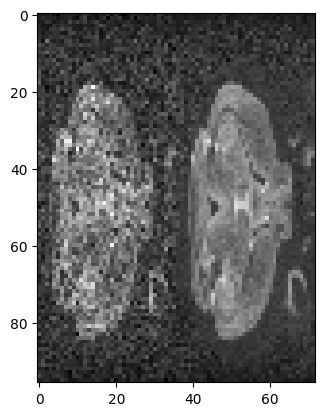

In [6]:
imshow(hcat(data1f[:,33,:,12],data1f_sm[:,33,:,12]),cmap="gray", interpolation="none");

### Increasing the image matrix size with data interpolation

In [7]:
slice_profile = convert(Array{Float32},[0.335, 0.33, 0.335]);
data1f_new = zeros(Float32,xdim,ydim,zdim*3+2,ddim);
data2f_new = zeros(Float32,xdim,ydim,zdim*3+2,ddim);
data3f_new = zeros(Float32,xdim,ydim,zdim*3+2,ddim);
data1f_new[:,:,1:3:end-2,:] = data1f_sm*slice_profile[1];
data1f_new[:,:,2:3:end-2,:] = data1f_sm*slice_profile[2];
data1f_new[:,:,3:3:end-2,:] = data1f_sm*slice_profile[3];
data2f_new[:,:,2:3:end-1,:] = data2f_sm*slice_profile[1];
data2f_new[:,:,3:3:end-1,:] = data2f_sm*slice_profile[2];
data2f_new[:,:,4:3:end-1,:] = data2f_sm*slice_profile[3];
data3f_new[:,:,3:3:end-0,:] = data3f_sm*slice_profile[1];
data3f_new[:,:,4:3:end-0,:] = data3f_sm*slice_profile[2];
data3f_new[:,:,5:3:end-0,:] = data3f_sm*slice_profile[3];
data1f2f3f_new = (data1f_new+data2f_new+data3f_new);

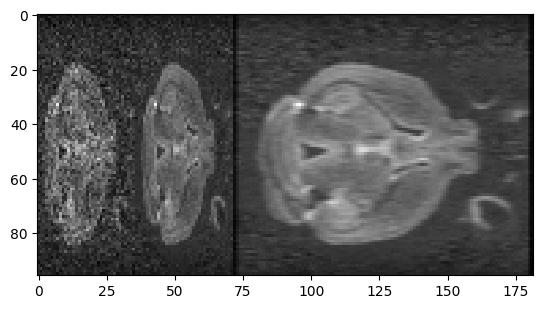

In [8]:
imshow(hcat(data3f[:,33,:,12],data3f_sm[:,33,:,12], data1f2f3f_new[:,33,:,12]),cmap="gray", interpolation="none");

### Super-resolution reconstruction
* it may take 1 min to run this cell

In [9]:
data_sr = SharedArray{Float32,4}((xdim,ydim,zdim*3+2,ddim)); # this is for parallel computation
tic()
@sync @parallel for cntd = 1:ddim
    datacombined = superresolution(data1f_sm[:,:,:,cntd],data2f_sm[:,:,:,cntd],data3f_sm[:,:,:,cntd],data1f2f3f_new[:,:,:,cntd],slice_profile);
    data_sr[:,:,:,cntd] = datacombined;
end
toc()
# superresolution source code is in library/myFun.jl

elapsed time: 66.449224552 seconds


66.449224552

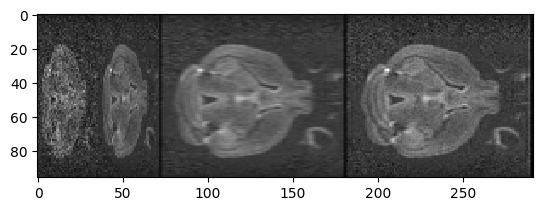

In [10]:
imshow(hcat(data3f[:,33,:,12],data3f_sm[:,33,:,12], data1f2f3f_new[:,33,:,12],data_sr[:,33,:,12]),cmap="gray", interpolation="none");

### Optionally denoising the super-resolution images
it may 2 min to run this cell

In [11]:
data_srcp = copy(data_sr);
@time data_sr_sm = denoisingDWI(data_srcp);

110.529263 seconds (6.38 k allocations: 278.700 MiB, 0.06% gc time)


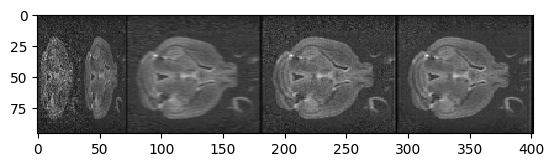

In [12]:
imshow(hcat(data3f[:,33,:,12],data3f_sm[:,33,:,12], data1f2f3f_new[:,33,:,12],data_sr[:,33,:,12],data_sr_sm[:,33,:,12]),cmap="gray", interpolation="none");


### Saving the results

In [13]:
data_sr_sm = 32000. * data_sr_sm / maximum(data_sr_sm[:]);
data_sr_sm = convert(Array{Int16}, round.(data_sr_sm));
headerinfo = deepcopy(headerinfoA)
headerinfo["dim"][4] = zdim*3+2
headerinfo["pixdim"][4] = headerinfo["pixdim"][4]/3f0
headerinfo["srow_z"][3] = headerinfo["srow_z"][3]/3f0
headerinfo["srow_z"][4] = headerinfo["srow_z"][4]/3f0
headerinfo["cal_max"] = Float32(32000);
newFileName = "data/images_SR.nii"
write_nii_header(newFileName, headerinfo);
fid = open(newFileName,"a");
write(fid, data_sr_sm);
close(fid);